# **Using kcm, troponin, blood pressure to classify heart disease patients.**
#### Zhanerke Zhumash, Gaveen Sran, Jeffery Shi, Lijie Wang 

## Introduction 
Cardiovascular diseases (CVDs) are the leading cause of death globally, taking an estimated 17.9 million lives each year [1]. CVDs are a group of disorders of the heart and blood vessels and include coronary heart disease, cerebrovascular disease, rheumatic heart disease and other conditions [1]. More than four out of five CVD deaths are due to heart attacks and strokes, and one third of these deaths occur prematurely in people under 70 years of age [2]. 

In this project, utilizing a database that captures key factors such as gender, age, blood glucose, and blood pressure of participants, we aim to develop a classification model to predict the likelihood of a new patient experiencing a heart attack.

By using a classification model, we would predict the presence of a heart attack based on the main predictors. The question we will be addressing is: **Is a new patient likely to have heart disease, based on age, blood pressure levels, troponing and kcm achieved?**
 

## Initialize the enviroment and import the packages

In [21]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

## Read CSV data file

In [31]:
url = "https://raw.githubusercontent.com/l-glucose/dsci100/main/data/heart_attack.csv"
data <- read_csv(url, show_col_types = FALSE)
data

age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
64,1,66,160,83,160,1.80,0.012,negative
21,1,94,98,46,296,6.75,1.060,positive
55,1,64,160,77,270,1.99,0.003,negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,85,168,104,96,1.24,4.250,positive
54,1,58,117,68,443,5.80,0.359,positive
51,1,94,157,79,134,50.89,1.770,positive


# Tidying the dataset

## Checking for NA values 

In [3]:
sum(is.na(data))

[1] 0

##  Converting a class column into a factor 

In [23]:
data <- data |>
    mutate(class = as_factor(class))

## Filtering impulse column for a maximim heart beat (200) (See [3])

In [24]:
data <- data |>
    filter(impluse <= 200)

(Optional) Trying out addition of pressure difference column for preliminary analysis

In [25]:
data <- data |>
    mutate(pressure_diff = pressurehight - pressurelow)

## Rename column names to grammatically correct versions

In [26]:
data_tidy <- data |>
  rename(
    pressure_high = pressurehight,
    pressure_low = pressurelow
  )

## Split to the training and testing data

In [27]:
data_split <- initial_split(data_tidy, prop = 0.75, strata = class) 
data_training <- training(data_split)
data_testing <- testing(data_split)

In [28]:
data_tidy

age,gender,impluse,pressure_high,pressure_low,glucose,kcm,troponin,class,pressure_diff
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
64,1,66,160,83,160,1.80,0.012,negative,77
21,1,94,98,46,296,6.75,1.060,positive,52
55,1,64,160,77,270,1.99,0.003,negative,83
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,85,168,104,96,1.24,4.250,positive,64
54,1,58,117,68,443,5.80,0.359,positive,49
51,1,94,157,79,134,50.89,1.770,positive,78


## Summary of the data

In [29]:
data_summary <- data_tidy |>
  group_by(class) |>
  summarize(
    min_age = min(age),
    max_age = max(age),
    mean_age = mean(age),
    male = sum(gender == 1),
    female = sum(gender == 0),
    min_impluse = min(impluse),
    max_impluse = max(impluse),
    mean_impluse = mean(impluse),
    min_pressure_high = min(pressure_high),
    max_pressure_high = max(pressure_high),
    mean_pressure_high = mean(pressure_high),
    min_pressure_low = min(pressure_low),
    max_pressure_low = max(pressure_low),
    mean_pressure_low = mean(pressure_low),
    min_glucose = min(glucose),
    max_glucose = max(glucose),
    mean_glucose = mean(glucose),
    min_kcm = min(kcm),
    max_kcm = max(kcm),
    mean_kcm = mean(kcm),
    min_troponin = min(troponin),
    max_troponin = max(troponin),
    mean_troponin = mean(troponin),
    number_of_samples = n()
  )

data_summary

class,min_age,max_age,mean_age,male,female,min_impluse,max_impluse,mean_impluse,min_pressure_high,⋯,min_glucose,max_glucose,mean_glucose,min_kcm,max_kcm,mean_kcm,min_troponin,max_troponin,mean_troponin,number_of_samples
<fct>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
negative,14,91,52.13386,307,201,20,132,75.85236,42,⋯,60,541,149.8911,0.321,7.02,2.555138,0.001,10.0,0.02702559,508
positive,19,103,58.76980,562,246,20,135,76.06436,65,⋯,35,541,144.7240,0.353,300.00,23.317994,0.003,10.3,0.57092574,808


# Comparing High Blood Pressure vs Age

## Selecting a sample with 100 data points to avoid overplotting

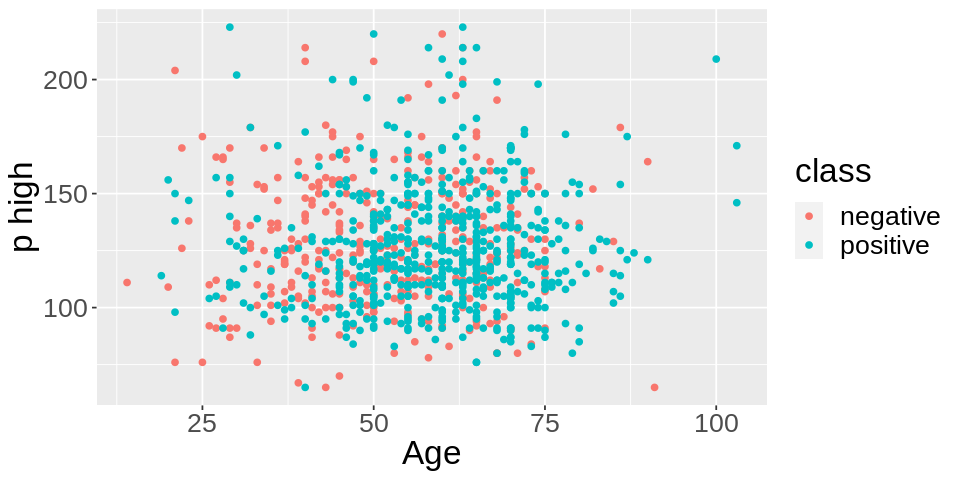

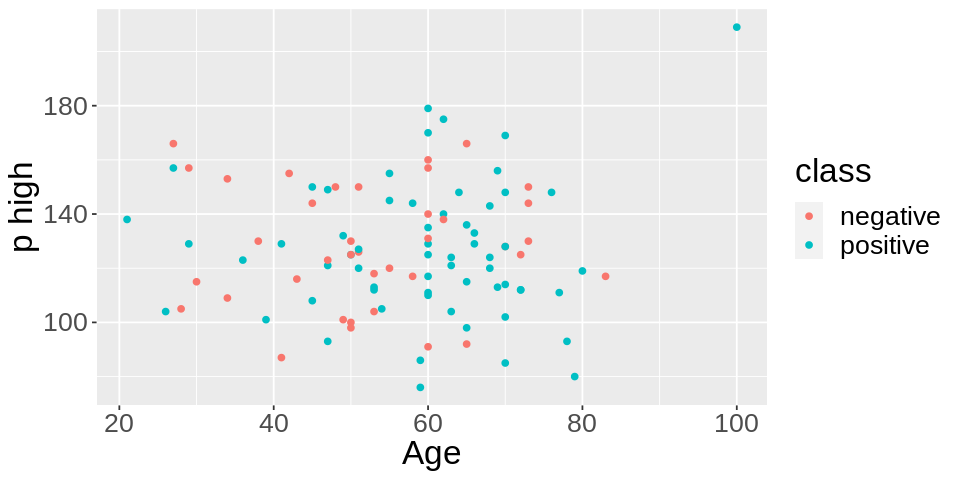

In [11]:
sample_100 <- sample_n(data_tidy, 100)
plot_diff <- data_training |> ggplot(aes(x = age, y = pressure_high, color = class)) + 
    geom_point() +
    xlab("Age") + 
    ylab("p high") +
    theme(text = element_text(size=20))


plot_sample <- sample_100 |> ggplot(aes(x = age, y = pressure_high, color = class)) + 
    geom_point() +
    xlab("Age") + 
    ylab("p high") +
    theme(text = element_text(size=20))

options(repr.plot.width = 8, repr.plot.height = 4) 

plot_diff
plot_sample


## Creating age groups to see the trend in BP vs. Age in detail 

In [12]:
create_age_group <- function(age) {
  if (age <= 20) {
    return("1-20")
  } else if (age <= 25) {
    return("21-25")
  } else if (age <= 30) {
    return("26-30")
  } else if (age <= 35) {
    return("31-35")
  } else if (age <= 40) {
    return("36-40")
  } else if (age <= 45) {
    return("41-45")
  } else if (age <= 50) {
    return("46-50")
  } else if (age <= 55) {
    return("51-55")
  } else if (age <= 60) {
    return("56-60")
  } else if (age <= 65) {
    return("61-65")
  } else if (age <= 70) {
    return("66-70")
  } else if (age <= 75) {
    return("71-75")
  } else {
    return("76-90")
  }
}

summarized_data <- data_training |>
  mutate(age_group = sapply(age, create_age_group)) |>
  group_by(age_group, class) |>
  summarise(across(where(is.numeric), mean, .names = "mean_{.col}"), .groups = "drop")

summarized_data 

age_group,class,mean_age,mean_gender,mean_impluse,mean_pressure_high,mean_pressure_low,mean_glucose,mean_kcm,mean_troponin,mean_pressure_diff
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1-20,negative,17.00000,0.5000000,83.50000,110.0000,63.00000,213.5,2.86,0.010000000,47.00000
1-20,positive,19.50000,0.5000000,61.00000,135.0000,64.50000,171.5,152.61,0.922000000,70.50000
21-25,negative,22.71429,0.5714286,69.57143,137.8571,77.28571,111.0,2.64,0.003714286,60.57143
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
71-75,positive,73.32653,0.5918367,76.12245,126.5714,72.24490,140.1020,15.098531,0.27034694,54.32653
76-90,negative,85.28571,0.5714286,66.71429,134.7143,75.85714,150.1429,3.298571,0.01128571,58.85714
76-90,positive,82.41860,0.5813953,77.44186,126.7674,72.06977,131.2326,29.220116,0.45002326,54.69767


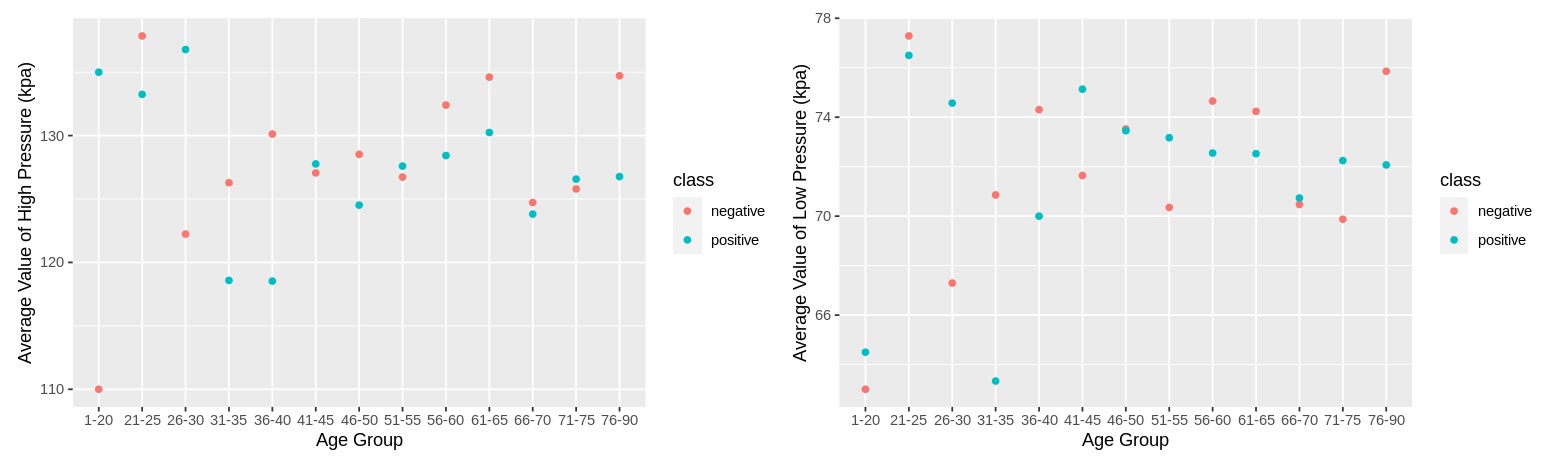

In [30]:
plot_data <- summarized_data |>
    slice()
plot_pressure_high <- summarized_data |> ggplot(aes(x = age_group, y = mean_pressure_high, color = class)) +
    geom_point() +
    xlab("Age Group") + 
    ylab("Average Value of High Pressure (kpa)")

plot_pressure_low <- summarized_data |> ggplot(aes(x = age_group, y = mean_pressure_low, color = class)) +
    geom_point() +
    xlab("Age Group") + 
    ylab("Average Value of Low Pressure (kpa)")
library(patchwork)
options(repr.plot.width = 13, repr.plot.height = 3.9) 

plot_pressure_high + plot_pressure_low


# KCM versus Age

In [17]:
#group by age and summarize by avberage kcm
data_age <- data_training |>
    group_by(age, class) |>
    summarize(kcm = mean(kcm, na.rm = TRUE))
data_age

`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


age,class,kcm
<dbl>,<fct>,<dbl>
14,negative,2.62
19,positive,300.00
20,negative,3.10
⋮,⋮,⋮
91,negative,5.37
100,positive,5.66
103,positive,60.64


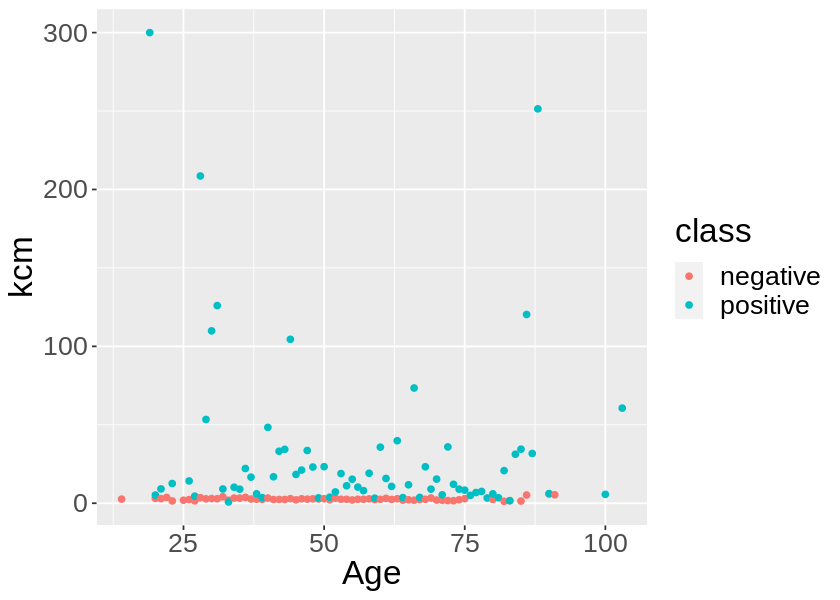

In [18]:
options(repr.plot.width = 7, repr.plot.height = 5) 
average_plot <- data_age |> ggplot(aes(x = age, y = kcm, color = class)) + 
    geom_point() +
    xlab("Age") + 
    ylab("kcm") +
    theme(text = element_text(size=20))
average_plot

# Troponin vs. Age

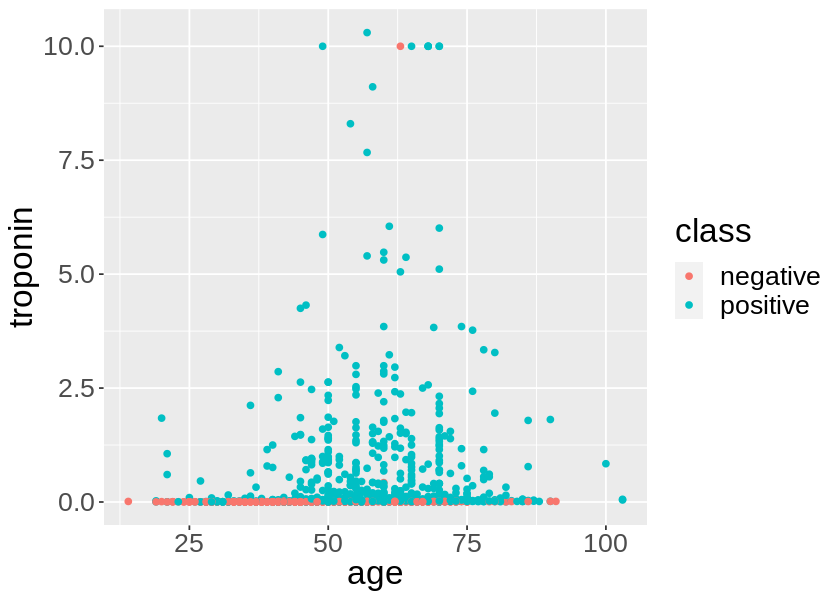

In [19]:
# for predictors 
plot2 <- data_tidy |> ggplot(aes(x = age, y = troponin, color = class)) + 
    geom_point() +
    xlab("age") + 
    ylab("troponin") +  
    theme(text = element_text(size=20))
plot2


## Methods
Since the variable “class”, which depicts the presence of a heart attack, is a categorical variable, we choose to conduct our data analysis by classification, specifically by using K nearest neighbors classification algorithm.

In order to help visualize our results and our predictions, we can plot a scatter plot to help determine what factors contribute to the presence of a heart attack. By using key visualizations concepts, such as coloring in different scatter points, and labeling our axis clearly, it can help make the graphs concise and easy to interpret. We will base our predictions on known indicators/predictors such as troponin levels, high/low blood pressure, and kcm values.

We are using the heart_attack.csv data from the Kaggle.com to predict if a patient will have heart disease. The columns are as follows:

1. **age**: age of the patients
2. **gender**: gender (1 = male, 0 = female)
3. **impulse**: heart rate
4. **pressure_hight**: systolic blood pressure (BP), high BP
5. **pressure_low**: diastolic BP, low BP
6. **glucose**: blood sugar
7. **kcm**: a blood test that looks for a specific enzyme.(CK-MB)
8. **troponin**: Test-Troponin
9. **class**: negative refers to the absence of a heart attack, while positive refers to the presence of a heart attack.

Each column is numeric-valued and there are 1316 rows in the clean data, with no missing data represented. In order to tidy the dataset, we renamed the BP columns and filtered impulse column to appropriate values.

To summarize the heart attack dataset, we grouped by class then summarized for the minimum, maximum and mean of each column. We noticed that the mean age of patients with heart attack is higher, as well as their kcm, tropolin. However, for mean high and low BP, the difference is not that significant. But we will still analyze as it showed some pattern when we grouped the age groups. For other columns, the difference between positive and negative classes were not substantial, so we are not focusing on them.

We used initial_split() to split our dataframe into 75% training and 25% testing data, stratifying for class. We used only the training set for analysis.

It is seen from **Troponin vs. Age**  plot that for **troponin** we need another predictor. It is possible that troponin and kcm could make an accurate prediction of heart attack.

Therefore, we have decided to make age, troponin, kcm our predictors. Potentially, we will compare it to High and Low BP predictors.

## Expected Outcome & Significance
After analyzing the heart disease dataset, we expect to determine whether a patient has had a heart attack using the K-nearest neighbors classification method. We will base our predictions on known indicators such as troponin levels, high/low blood pressure, and kcm values.

Utilizing comprehensive databases for such predictions is a crucial initiative. Given the substantial risks associated with cardiovascular diseases, early detection can greatly improve treatment outcomes and has the potential to save lives.

In addition, we provid some future questions that the dataset might to lead:

Are there other classification models that can help predict the data accurately, such as using different predictors?
How are the prevalence and risk factors of heart disease evolving over time, and what might this suggest for the future?


### Bibliography 
-  [1] https://www.who.int/health-topics/cardiovascular-diseases
-  [2] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6011508/
-  [3] https://www.mayoclinic.org/healthy-lifestyle/fitness/expert-answers/heart-rate/faq-20057979#:~:text=A%20normal%20resting%20heart%20rate%20for%20adults%20ranges%20from%2060,function%20and%20better%20cardiovascular%20fitness.